# HDF4Water - Tutorial

## Introduction

This jupyter notebook contains a tutorial elaborating how to leverage AtlasHDF python module for a specific domain example: that is to resolve, process, and analysis surface water bodies with OpenStreetMap (OSM) and Sentinel-2 MSI data in the region of Oberbayern. 

If you are interested in learning how the AtlasHDF organize and process the OSM data with HDF5, please check out the paper [AtlasHDF: An Efficient Big Data Framework for GeoAI](https://dl.acm.org/doi/10.1145/3557917.3567615)

## Learning Objectives:

After completing this tutorial, you will be able to:
- Import and use Python packages `numpy`, `matplotlib`, `h5py`, and `atlashdf`;
- Download OSM data of Oberbayern from geofabrik;
- Customrize the attribute query on OSM data and set up the object filter;
- Use the developed `atlashdf` package for the OSM data mapping, querying, and triangulating into a `.h5` data container;
- Use the `h5py` to add Sentinel-2 MSI data into the existing container for futher GeoAI application.

For more information on the motivation of `atlashdf` watch this video

In [2]:
# Display the promotion video
from IPython.display import Video
Video("assets/AtlasHDF_promotion.mp4", width=560, height=315)

## Step1: set up

Before we start coding, make sure you are using the correct version of Python (currently, the tutorial was tested against Python version 3.7). 

In [3]:
#Check that you are using the correct version of Python (should be 3.7+)
import sys
sys.version

'3.7.3 (default, Oct 31 2022, 14:04:00) \n[GCC 8.3.0]'

First let's import the required package for this tutorial, e.g., `numpy`, `h5py`, `matplotlib`, etc. Especially, in order to use the nice `atlashdf` python module, you will need to compile a valid wheel for the developed `atlashdf` package and install it with `pip install`. For this purpose, we provide a dedicated Dockerfile in `atlashdf/python_module/Dockerfile`. 

In the future, we aim to support more concise installation, e.g., `pip install atlashdf`, with further development.

In [26]:
import matplotlib.pyplot as plt
import rasterio
import urllib.request
import numpy as np
import os
import h5py
import atlashdf
from rasterio.plot import show

### Step2: Download OSM data for Oberbayern

Next, we get the latest OSM data from [Geofabrik download server](https://download.geofabrik.de/). The raw OSM data is availbe in `.osm.pbf` format, which is a low-level Protocolbuffer Binary Format (PBF) files.

In [5]:
inputfile="oberbayern-latest.osm.pbf"

In [6]:
# Ensure, we have a file
if not os.path.exists(inputfile):
    print("Downloading Oberbayern")
    urllib.request.urlretrieve("https://download.geofabrik.de/europe/germany/bayern/oberbayern-latest.osm.pbf", "oberbayern-latest.osm.pbf")
print("Using Oberbayern. Delete file for an update from the Internet")

Using Oberbayern. Delete file for an update from the Internet


### Step3: Initialize OSM query and object filter for AtlasHDF

Querying in AtlasHDF is empowered by [JQ](https://stedolan.github.io/jq/manual/v1.5/), which is a lightweight and flexible command-line JSON processor. We beleive the JQ query can be a beast together with HDF5. 

To initialize a query of surface water polygons in OSM, an example JQ query could look like the following: 

In [7]:
x = atlashdf.AtlasHDF();

In [8]:
# Conversion Chain
attribute_selection_query="""
{"iswater":(.waterway != null or .natural == "water" or .natural == "wetland" or .water != null or .landuse=="water" or .landcover=="water")} 
"""

object_filter="""
select(.iswater)
"""


This example would select all polygons with a tag `natural==water` and then suppresses all other attributes by building a new output object. In essence, if the `natural==water` is not present, it will suppress the whole polygon entry, if it is there, the attributes will be `{"natural":"water"}` but can be extended in the query.

Any empty result `null` leads to omit of the nodes, ways, and relations. In a common setting, JQ queries will first be used to suppress all elements that we are not interested in.

### Step4: Immediate Mapping and resolving of OSM data with AtlasHDF

In this part, we called key functions of AtlasHDF with the attribute query we initialized in Step3. More specificall, the AtlasHDF supports four major functions at this moment:

- First with `.def("import_immediate", &AtlasHDF::import_immediate)`, one can do the immediate mapping of OSM nodes, ways, and relations into points, polylines, and polygons;
- Second with `.def("set_filter", &AtlasHDF::set_filter)`, one can apply the attribute query on the OSM data;
- Thrid with `.def("resolve", &AtlasHDF::resolve)`, one can do analysis-ready mapping of OSM multipolygons with selected triangulation methods (currently, we use [earcut](https://github.com/mapbox/earcut) for the triangulation purpose);
- Last but not the least with `.def("set_container", &AtlasHDF::set_container)`, one can identify the output HDF5 data container.

The following code will take the downloaed OSM data for Oberbayer and apply attribute query from Step3 with these AtlasHDF functions: 

In [9]:
x = (x.set_container("oberbayern-water-earcut.h5")
     .set_filter("nodes",attribute_selection_query)
     .set_filter("ways",attribute_selection_query) 
     .set_filter("relations",attribute_selection_query)
     .import_immediate(inputfile)
     .clear_filters()
     .set_filter("ways",object_filter)
     .resolve("earcut")#"earcut")
     )

ChunkedOSMImmediateWriter
Activating a JQrunner for nodes with 
{"iswater":(.waterway != null or .natural == "water" or .natural == "wetland" or .water != null or .landuse=="water" or .landcover=="water")} 

Activating a JQrunner for ways with 
{"iswater":(.waterway != null or .natural == "water" or .natural == "wetland" or .water != null or .landuse=="water" or .landcover=="water")} 

Activating a JQrunner for relations with 
{"iswater":(.waterway != null or .natural == "water" or .natural == "wetland" or .water != null or .landuse=="water" or .landcover=="water")} 

[INFO] Reading the file oberbayern-latest.osm.pbf
[INFO] We finished reading the file
Resolving geometries using earcut
Resolving ways...
Node count: 18959091
Way count: 2858266
Resolving relations...
Way count: 2858266
Relation count: 39462


Now, once the data container is successfully generated, we can insepect the datasets with `h5py` package.

In [10]:
#Inspect the OSM data contianer including the results from immediate ana analysis-ready mapping
f = h5py.File("oberbayern-water-earcut.h5")

In [11]:
#list_dataset lists the names of datasets in an hdf5 file
def list_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name)

f.visititems(list_dataset)

osm/linestrings
osm/linestrings_idx
osm/nodes
osm/nodes_attr
osm/nodes_coords
osm/relations
osm/relations_attr
osm/relations_refs
osm/relations_triangles
osm/relations_triangles_idx
osm/ways
osm/ways_attr
osm/ways_refs
osm/ways_triangles
osm/ways_triangles_idx


In [12]:
#ls_dataset displays the name, shape, and type of datasets in hdf5 file
def ls_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(node)
    
f.visititems(ls_dataset)

<HDF5 dataset "linestrings": shape (397059, 2), type "<f8">
<HDF5 dataset "linestrings_idx": shape (20917, 2), type "<u4">
<HDF5 dataset "nodes": shape (18959091, 1), type "<u8">
<HDF5 dataset "nodes_attr": shape (18959091, 1), type "|O">
<HDF5 dataset "nodes_coords": shape (18959091, 2), type "<f8">
<HDF5 dataset "relations": shape (39462, 1), type "<u8">
<HDF5 dataset "relations_attr": shape (39462, 1), type "|O">
<HDF5 dataset "relations_refs": shape (39462, 1), type "|O">
<HDF5 dataset "relations_triangles": shape (0, 2), type "<f8">
<HDF5 dataset "relations_triangles_idx": shape (39462, 2), type "<u4">
<HDF5 dataset "ways": shape (2858266, 1), type "<u8">
<HDF5 dataset "ways_attr": shape (2858266, 1), type "|O">
<HDF5 dataset "ways_refs": shape (2858266, 1), type "|O">
<HDF5 dataset "ways_triangles": shape (1002924, 2), type "<f8">
<HDF5 dataset "ways_triangles_idx": shape (20917, 2), type "<u4">


In [13]:
f.close()

### Step5: Add Sentinel-2 MSI raster data into the data container

In [110]:
# define the Sentinel-2 file
S2_inputfile="oberbayern_S2_10m_subset.tif"

In [111]:
# if non-existing, download from TUM syn&share
if not os.path.exists(S2_inputfile):
    print("Downloading Oberbayern Setinel-2 Image!")
    urllib.request.urlretrieve("https://syncandshare.lrz.de/dl/fiCxcVfPcTV6i7QBbRBC7Y/Oberbayern_S2_10m_subset.tif?inline", "oberbayern_S2_10m_subset.tif")

print("Successfully download the Sentinel-2 image for Oberbayern!")

Successfully download the Sentinel-2 image for Oberbayern!


In [112]:
# open a hdf5 file
f = h5py.File("oberbayern-water-earcut.h5", 'a') 

In [113]:
# read the image using rasterio
S2_data = rasterio.open(S2_inputfile)

In [114]:
# write the data to hdf5 file
dset = f.create_dataset('Sentinel-2', data=S2_data.read())

In [116]:
f.visititems(ls_dataset)

<HDF5 dataset "Sentinel-2": shape (4, 4137, 5587), type "<u2">
<HDF5 dataset "linestrings": shape (397059, 2), type "<f8">
<HDF5 dataset "linestrings_idx": shape (20917, 2), type "<u4">
<HDF5 dataset "nodes": shape (18959091, 1), type "<u8">
<HDF5 dataset "nodes_attr": shape (18959091, 1), type "|O">
<HDF5 dataset "nodes_coords": shape (18959091, 2), type "<f8">
<HDF5 dataset "relations": shape (39462, 1), type "<u8">
<HDF5 dataset "relations_attr": shape (39462, 1), type "|O">
<HDF5 dataset "relations_refs": shape (39462, 1), type "|O">
<HDF5 dataset "relations_triangles": shape (0, 2), type "<f8">
<HDF5 dataset "relations_triangles_idx": shape (39462, 2), type "<u4">
<HDF5 dataset "ways": shape (2858266, 1), type "<u8">
<HDF5 dataset "ways_attr": shape (2858266, 1), type "|O">
<HDF5 dataset "ways_refs": shape (2858266, 1), type "|O">
<HDF5 dataset "ways_triangles": shape (1002924, 2), type "<f8">
<HDF5 dataset "ways_triangles_idx": shape (20917, 2), type "<u4">


In [117]:
# close the AtlasHDF data container
f.close()

### Step6: Read and Visualize the Sentinel-2 MSI data as RGB composite.

In [118]:
# open a hdf5 file
f = h5py.File("oberbayern-water-earcut.h5", 'a') 

In [119]:
# read the data from hdf5 file
image_data = np.array(f["Sentinel-2"])   

In [120]:
# check the size of data
print(image_data.shape)

(4, 4137, 5587)


In [121]:
# get the RGB band
red = image_data[0,:,:]
green = image_data[1,:,:]
blue = image_data[2,:,:]

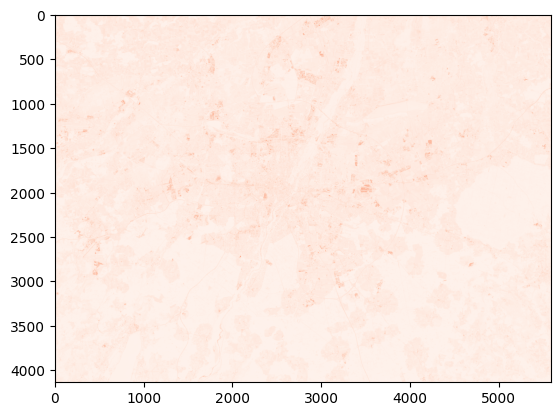

In [122]:
# plot the Red channel
plt.imshow(red, cmap='Reds')

In [124]:
#define basic image processing functions
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0,255)

# image enahcing using the normalize and brighten function
red_b=brighten(red)
blue_b=brighten(blue)
green_b=brighten(green)

red_bn = normalize(red_b)
green_bn = normalize(green_b)
blue_bn = normalize(blue_b)

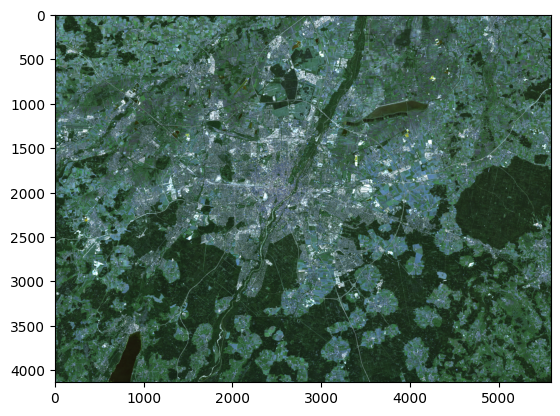

In [125]:
# create the RGB composite and visualize it
rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
plt.imshow(rgb_composite_bn)

In [126]:
# close the AtlasHDF data container
f.close()

### Congratulations! You successfully went through the tutorial of AtlasHDF!

### For any questions, reach out us in  https://github.com/tum-bgd/atlashdf

Acknowledge: The project team acknowledge the support from NFDI Consortium Earth System Sciences (NFDI4Earth), which is funded by Deutsche Forschungsgemeinschaft (DFG), project number: 460036893.